In [148]:
import json
import jiwer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from collections import Counter


In [149]:
# Pre-compiled transformations and evaluators
_TRANSFORMATION = jiwer.Compose([
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemoveEmptyStrings(),
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.Strip(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords()
])
_ROUGE = Rouge()
_SMOOTH = SmoothingFunction().method4


def compute_metrics(ref: str, hyp: str) -> dict:
    """
    Compute WER, BLEU, and ROUGE-L for a single reference/hypothesis pair.
    """
    ref, hyp = ref.strip(), hyp.strip()
    wer = jiwer.wer(ref, hyp,
                   truth_transform=_TRANSFORMATION,
                   hypothesis_transform=_TRANSFORMATION)
    bleu = sentence_bleu([ref.split()], hyp.split(), smoothing_function=_SMOOTH)
    try:
        rouge_l = _ROUGE.get_scores(hyp, ref)[0]["rouge-l"]["f"]
    except Exception:
        rouge_l = None
    return {"token_error_rate": wer, "bleu_score": bleu, "rouge_l": rouge_l}


def enrich_results(results: list) -> list:
    """
    Add metric scores to each item in a results list.
    """
    for item in results:
        metrics = compute_metrics(item["expected_answer"], item["generated_answer"])
        item.update(metrics)
    return results

In [150]:
def load_json(path: str) -> list:
    with open(path, encoding="utf-8") as f:
        return json.load(f)


def save_json(path: str, data: list) -> None:
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)


def load_and_process(pairs: list) -> dict:
    """
    Load, enrich, and save result sets. Returns a dict of label → enriched list.
    """
    enriched = {}
    for label, infile, outfile in pairs:
        data = load_json(infile)
        enriched[label] = enrich_results(data)
        save_json(outfile, enriched[label])
    return enriched

In [151]:
def plot_histograms(datasets: dict, metric):
    """
    Plot histograms and KDEs of token error rates.
    datasets: mapping from (group,label) to list of WER floats.
    Expects keys like ('no_expert', 'basic'), etc.
    """
    # Extract all rates
    rates = {k: [d[metric] for d in v] for k, v in datasets.items()}

    # Global axis limits
    all_vals = np.concatenate(list(rates.values()))
    x_min, x_max = all_vals.min(), all_vals.max() * 1.1
    x_grid = np.linspace(x_min, x_max, 200)
    global_y_max = max(gaussian_kde(vals)(x_grid).max() for vals in rates.values()) * 1.8

    # Plot settings
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    config = [
        (('no_expert', 'basic'), 'No Expert (Básico)', 'skyblue', 'blue'),
        (('no_expert', 'advanced'), 'No Expert (Avanzado)', 'skyblue', 'blue'),
        (('no_expert', 'langchain'), 'No Expert (Langchain)', 'skyblue', 'blue'),
        (('expert', 'basic'), 'Expert (Básico)', 'orange', 'red'),
        (('expert', 'advanced'), 'Expert (Avanzado)', 'orange', 'red'),
        (('expert', 'langchain'), 'Expert (Langchain)', 'orange', 'red'),
    ]

    for ax, (key, title, hist_color, kde_color) in zip(axes.flatten(), config):
        vals = rates[key]
        kde = gaussian_kde(vals)
        ax.hist(vals, bins=10, density=True, alpha=0.6,
                color=hist_color, edgecolor='black', label=f'{title}')
        ax.plot(x_grid, kde(x_grid), color=kde_color, lw=2,
                label=f'KDE {title}')
        ax.set(title=f"Histograma {title} de Token Error Rate",
               xlabel="Token Error Rate", ylabel="Densidad",
               xlim=(x_min, x_max), ylim=(0, global_y_max))
        ax.legend()

    plt.tight_layout()
    plt.show()

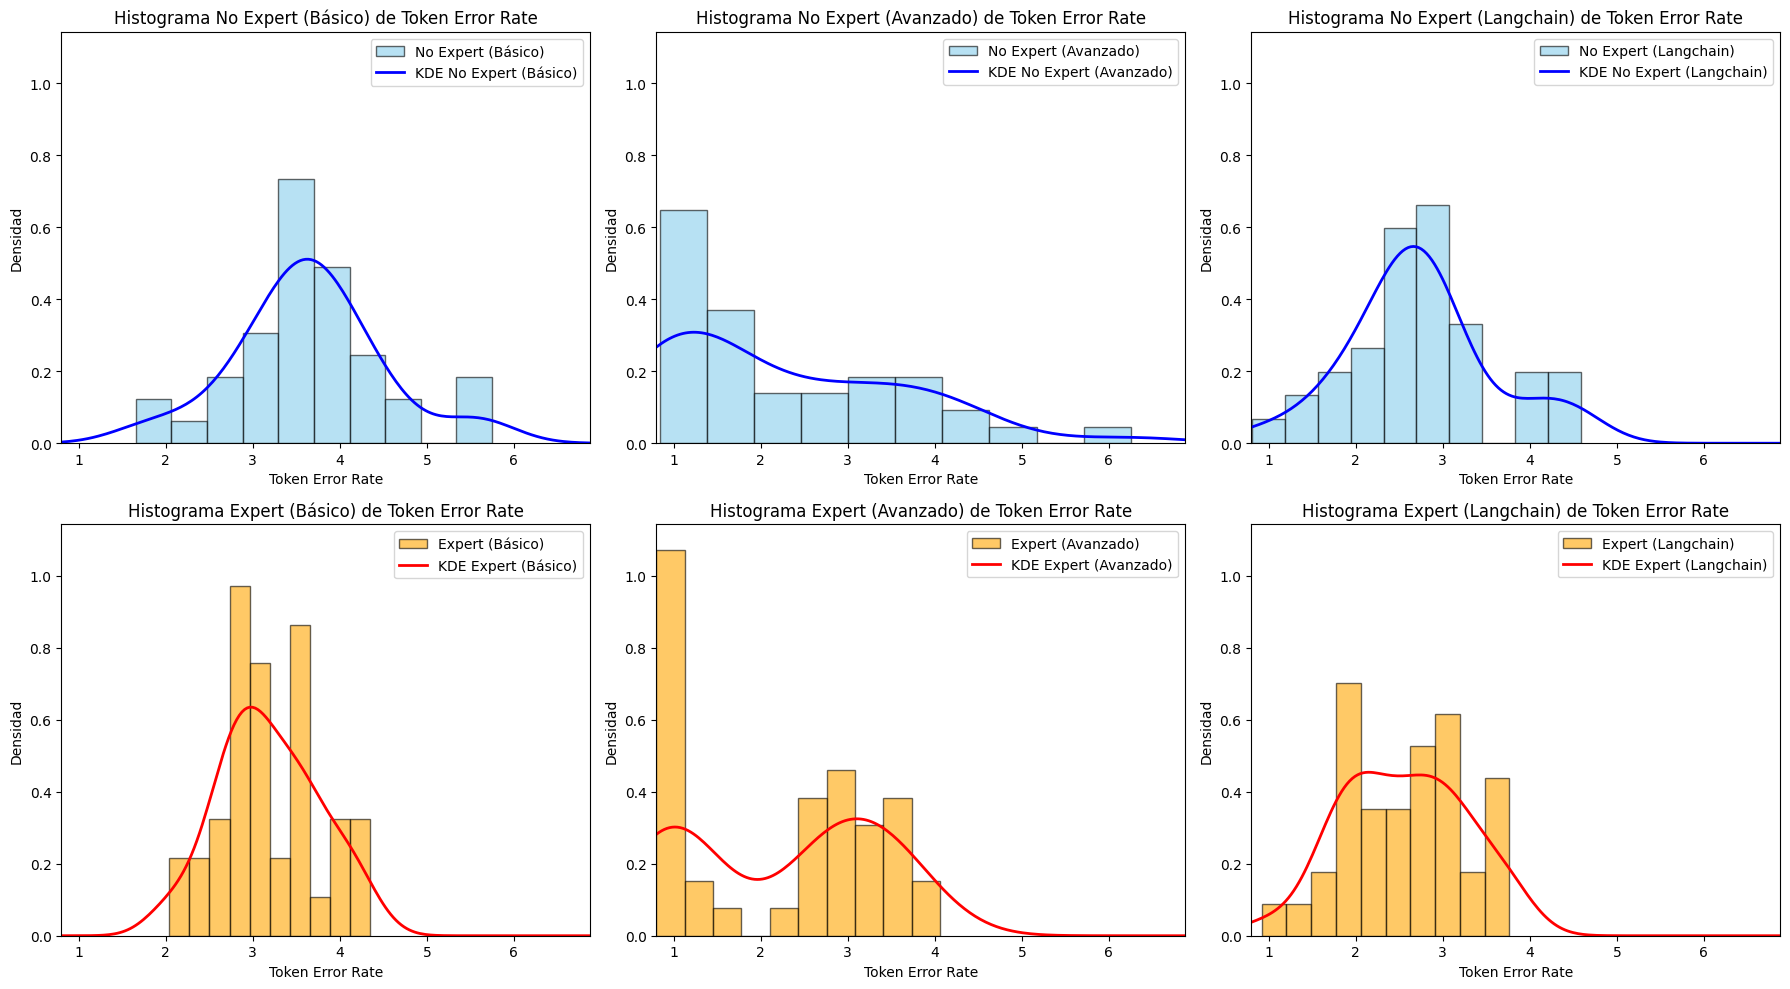

In [152]:

# Define file triads: (label, input path, output path)
basic = [
    ('basic_no_expert', 'nonExpert_results_basic.json', 'nonExpert_answers_basic.json'),
    ('basic_expert', 'expert_answers_basic.json',    'expert_results_basic.json')
]
advanced = [
    ('adv_no_expert', 'nonExpert_answers_advanced.json', 'nonExpert_answers_advanced.json'),
    ('adv_expert',   'expert_answers_advanced.json',     'expert_results_advanced.json')
]
langchain = [
    ('lang_no_expert', 'nonExpert_answers_langchain.json', 'nonExpert_answers_langchain.json'),
    ('lang_expert',    'expert_answers_langchain.json',    'expert_results_langchain.json')
]

# Process all sets
enriched = {}
enriched.update(load_and_process(basic))
enriched.update(load_and_process(advanced))
enriched.update(load_and_process(langchain))

# Plot distributions
# Map shortened keys to tuple keys
mapping = {
    ('no_expert', 'basic'):   enriched['basic_no_expert'],
    ('expert', 'basic'):      enriched['basic_expert'],
    ('no_expert', 'advanced'): enriched['adv_no_expert'],
    ('expert', 'advanced'):    enriched['adv_expert'],
    ('no_expert', 'langchain'): enriched['lang_no_expert'],
    ('expert', 'langchain'):    enriched['lang_expert'],
}
plot_histograms(mapping, 'token_error_rate')


In [153]:
def plot_bars(json_files):
    # Definimos las categorías (puntuaciones) en orden
    categories = [1, 2, 3, 4, 5]
    labels = [
        '1: Error al generar la respuesta',
        '2: Respuesta incorrecta',
        '3: Respuesta incompleta',
        '4: Respuesta mayormente correcta',
        '5: Respuesta totalmente correcta'
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    config = [
        (('no_expert', 'basic'), 'No Expert (Básico)', 'skyblue', 'blue'),
        (('no_expert', 'advanced'), 'No Expert (Avanzado)', 'skyblue', 'blue'),
        (('no_expert', 'langchain'), 'No Expert (Langchain)', 'skyblue', 'blue'),
        (('expert', 'basic'), 'Expert (Básico)', 'orange', 'red'),
        (('expert', 'advanced'), 'Expert (Avanzado)', 'orange', 'red'),
        (('expert', 'langchain'), 'Expert (Langchain)', 'orange', 'red'),
    ]

    for ax, (key, title, color, kde_color), file_path in zip(axes.flatten(), config, json_files):
        # Cargar el JSON
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Contar las puntuaciones llm_score
        scores = [item['llm_score'] for item in data]
        counter = Counter(scores)

        # Preparar los datos para las barras, asegurando el orden 1–5
        counts = [counter.get(cat, 0) for cat in categories]
        x_pos = range(len(labels))

        print(f'{title}: {scores}')

        # Crear el gráfico de barras
        ax.bar(x_pos, counts, color=f'{color}')
        ax.set_title(f'{title}: Distribución de Puntuaciones')
        ax.set_xlabel('Categoría de Puntuación')
        ax.set_ylabel('Número de Respuestas')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

No Expert (Básico): [4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 3, 3, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
No Expert (Avanzado): [3, 3, 3, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 4, 5, 5, 4, 3, 4, 5]
No Expert (Langchain): [3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3]
Expert (Básico): [5, 4, 4, 4, 3, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 2, 4, 5, 4, 5, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 3, 4, 5, 3, 3, 3, 4, 5]
Expert (Avanzado): [3, 4, 4, 4, 5, 5, 3, 4, 3, 5, 4, 4, 3, 5, 3, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 3, 5, 3, 3, 5, 3, 5, 5, 3, 5, 5, 5, 3]
Expert (Langchain): [5, 3, 3, 3, 4, 4, 3, 4, 5, 3, 5, 5, 5, 5]


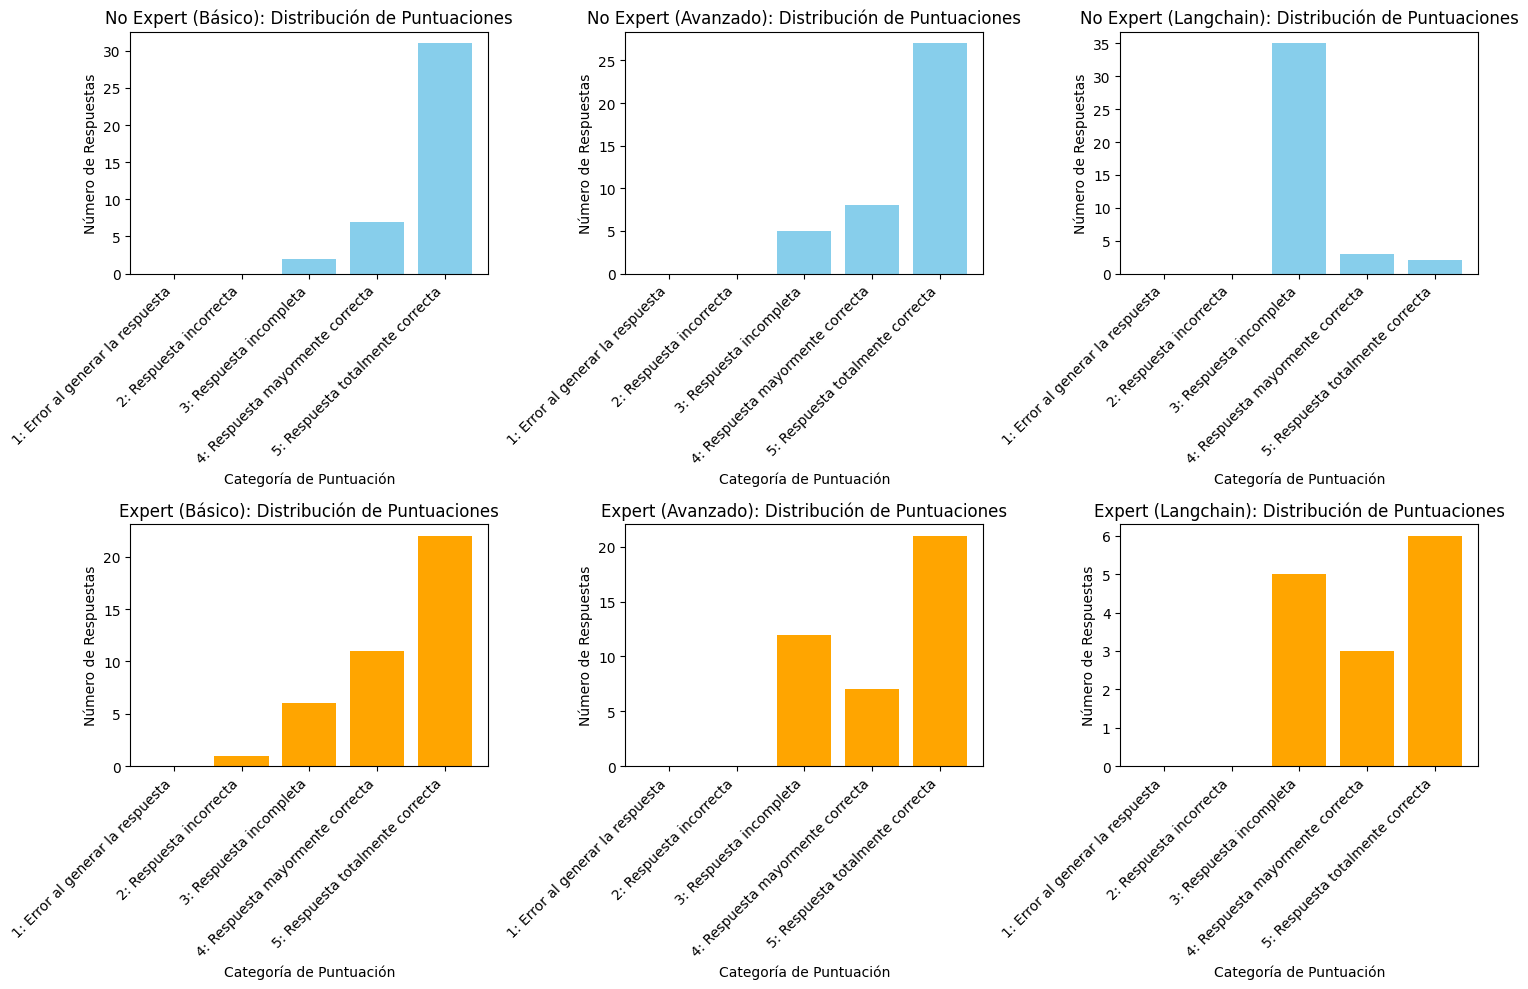

In [154]:
# Plot distributions
# Map shortened keys to tuple keys
json_files = {
    'nonExpert_results_basic_llm.json',
    'expert_results_basic_llm.json',
    'nonExpert_results_advanced_llm.json',
    'expert_results_advanced_llm.json',
    'nonExpert_results_langchain_llm.json',
    'expert_results_langchain_llm.json'
}
plot_bars(json_files)
